In [5]:
import pandas as pd
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"

In [6]:
df = pd.read_csv(DATASET_LOC)
df.head(10)

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
5,27,2020-03-07 23:18:15,APPNP and PPNP,"A PyTorch implementation of ""Predict then Prop...",other
6,28,2020-03-07 23:23:46,Attributed Social Network Embedding,A sparsity aware and memory efficient implemen...,other
7,29,2020-03-07 23:45:38,Signed Graph Convolutional Network,"A PyTorch implementation of ""Signed Graph Conv...",other
8,45,2020-03-08 00:39:08,SimGNN,"A PyTorch implementation of ""SimGNN: A Neural ...",other
9,61,2020-03-16 17:35:22,Using JAX to Improve Separable Image Filters,Optimizing the filters to improve the filtered...,computer-vision


In [7]:
df.count()

id             764
created_on     764
title          764
description    764
tag            764
dtype: int64

In [8]:
import matplotlib.pyplot as plt

<Axes: ylabel='tag'>

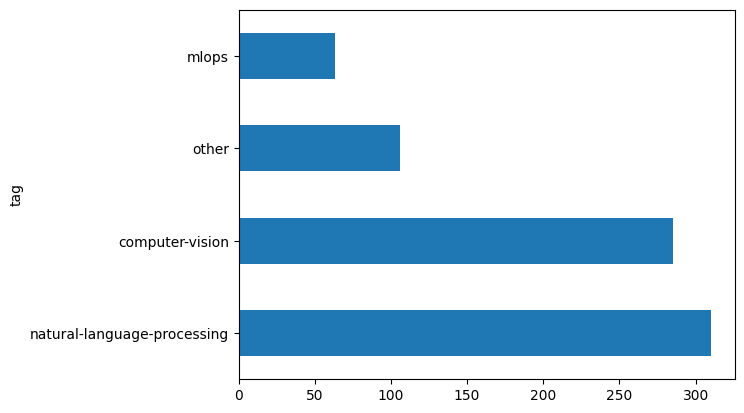

In [9]:
df['tag'].value_counts().plot(kind='barh')
#plt.xticks(rotation=0)
#plt.show()


In [10]:
df['text'] = df['title'] + df['description']

In [4]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [11]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mukammedalimbet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def clean_text(text, stopwords=STOPWORDS):
    text = text.lower()
    
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) 
    text = re.sub(" +", " ", text) 
    text = text.strip()  
    text = re.sub(r"http\S+", "", text)  
    
    return text

In [13]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videosBringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videosbringing theory experiment cool easily train models colab find results minutes


In [14]:
df = df.drop(columns=["id", "created_on", "title", "description"], errors = "ignore")
df = df.dropna(subset=["tag"])
df = df[["text", "tag"]]
df.head()

,text,tag
0,comparison yolo rcnn real world videosbringing...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classificationa collection impor...,other
3,awesome monte carlo tree searcha curated list ...,other
4,attentionwalka pytorch implementation watch st...,other


In [15]:
tags = df['tag'].unique().tolist()
tags_dictionary = {}
n = 0
for i in tags:
    tags_dictionary[i] = n
    n += 1
print(tags_dictionary)

{'computer-vision': 0, 'other': 1, 'natural-language-processing': 2, 'mlops': 3}


In [16]:
df["tag"] = df["tag"].map(tags_dictionary)
df.head()

,text,tag
0,comparison yolo rcnn real world videosbringing...,0
1,show infer tell contextual inference creative ...,0
2,awesome graph classificationa collection impor...,1
3,awesome monte carlo tree searcha curated list ...,1
4,attentionwalka pytorch implementation watch st...,1


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


2025/02/22 11:44:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/02/22 11:45:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['tag'], stratify=df['tag'], test_size=0.2, random_state=42)


In [18]:
#distribution of classes in train and test sets
print(y_train.value_counts())
print(y_test.value_counts())

tag
2    248
0    228
1     85
3     50
Name: count, dtype: int64
tag
2    62
0    57
1    21
3    13
Name: count, dtype: int64


In [19]:
X_test

165    stefann scene text editor using font adaptive ...
267    deep love transfer learning nlp review nlp res...
108    graph netspytorch implementation explanation g...
628    neuralqa api visual interface extractive qaa u...
382    leafy plant leaf classifierthe sequential mode...
                             ...                        
297    plant disease detectionthis website help detec...
292    content style disentanglement artistic style t...
232    injecting inductive bias graph neural networks...
239    danet pytorcha pytorch implementation dual att...
580    tensorflow js object detection browsera real t...
Name: text, Length: 153, dtype: object

In [20]:
from sklearn.preprocessing import FunctionTransformer

# Create a pipeline with a conversion step
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("lr", LogisticRegression(class_weight='balanced'))
])

# Fit and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

2025/02/22 11:45:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd0570fb6ca8348e9833bbead09514ec1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/02/22 11:45:20 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/02/22 11:45:23 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


              precision    recall  f1-score   support

           0       0.87      0.91      0.89        57
           1       0.92      0.57      0.71        21
           2       0.85      0.92      0.88        62
           3       0.85      0.85      0.85        13

    accuracy                           0.86       153
   macro avg       0.87      0.81      0.83       153
weighted avg       0.87      0.86      0.86       153



In [21]:
report = classification_report(y_test, y_pred,  output_dict=True)

In [113]:
report

{'0': {'precision': 0.8666666666666667,
  'recall': 0.9122807017543859,
  'f1-score': 0.8888888888888888,
  'support': 57.0},
 '1': {'precision': 0.9230769230769231,
  'recall': 0.5714285714285714,
  'f1-score': 0.7058823529411765,
  'support': 21.0},
 '2': {'precision': 0.8507462686567164,
  'recall': 0.9193548387096774,
  'f1-score': 0.8837209302325582,
  'support': 62.0},
 '3': {'precision': 0.8461538461538461,
  'recall': 0.8461538461538461,
  'f1-score': 0.8461538461538461,
  'support': 13.0},
 'accuracy': 0.8627450980392157,
 'macro avg': {'precision': 0.8716609261385381,
  'recall': 0.8123044895116203,
  'f1-score': 0.8311615045541175,
  'support': 153.0},
 'weighted avg': {'precision': 0.8662149283747177,
  'recall': 0.8627450980392157,
  'f1-score': 0.8580450572081698,
  'support': 153.0}}

In [73]:
from typing import List
import numpy as np

def test_model_behaviour(pipeline, text_template: str, variations: List[str]) -> None:
    """
    Test if model predictions stay same when words are substituted.
    
    Args:
        pipeline: Your trained sklearn pipeline
        text_template: Text with {} where word will be replaced
        variations: List of words to try
    """
    # Generate different versions of the text
    texts = [text_template.format(word) for word in variations]
    
    # Get predictions for all variations
    predictions = [pipeline.predict([text])[0] for text in texts]
    
    # Check if all predictions are the same
    is_consistent = len(set(predictions)) == 1
    
    # Print results
    print("\nInvariance Test Results:")
    print("------------------------")
    print("Original variations:")
    for text, pred in zip(texts, predictions):
        print(f"Text: {text}")
        print(f"Prediction: {pred}")
        print()
    print(f"All predictions same? {is_consistent}")
    
# Example usage
variations = [
    "changed",
    "revolutionized"
]

template = "Transformers applied to NLP have {} the ML field."

# Run the test
test_model_behaviour(pipeline, template, variations)




Invariance Test Results:
------------------------
Original variations:
Text: Transformers applied to NLP have changed the ML field.
Prediction: 2

Text: Transformers applied to NLP have revolutionized the ML field.
Prediction: 2

All predictions same? True


In [74]:
# N2 DIRectional expectations (changes with known outputs)
variations2 = [
    "text classification",
    "image classification"
]

template2 = "ML applied to {}"

# Run the test
test_model_behaviour(pipeline, template2, variations2)


Invariance Test Results:
------------------------
Original variations:
Text: ML applied to text classification
Prediction: 2

Text: ML applied to image classification
Prediction: 0

All predictions same? False


In [75]:

# N3 minimum functionality (Simple combination of inputs and expected outputs)
variations3 = [
    "natural language processing", 
    "mlops"
]

template3 = "{} is the next big wave in machine learning."

# Run the test
test_model_behaviour(pipeline, template3, variations3)


Invariance Test Results:
------------------------
Original variations:
Text: natural language processing is the next big wave in machine learning.
Prediction: 2

Text: mlops is the next big wave in machine learning.
Prediction: 3

All predictions same? False


#### Experiment Tracking

In [27]:
import mlflow
from mlflow import MlflowClient
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Log_Reg_Text_Classification")

def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts


mlflow.sklearn.autolog()
with mlflow.start_run(run_name="logging_models") as run:

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ("lr", LogisticRegression(class_weight='balanced', solver='saga', tol=1e-2, max_iter=200,
                              random_state=0))
    ])

    distributions = dict(lr__C=uniform(loc=0, scale=4), 
                         lr__penalty=['l2', 'l1'])    
    clf = RandomizedSearchCV(pipeline, distributions, random_state=0)


    search = clf.fit(X_train, y_train)
    y_pred = search.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))


2025/02/22 12:02:14 INFO mlflow.tracking.fluent: Experiment with name 'Log_Reg_Text_Classification' does not exist. Creating a new experiment.
2025/02/22 12:02:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/02/22 12:02:14 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
/Users/mukammedalimbet/personal_coding/madewithml/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mukammedalimbet/personal_coding/madewithml/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mukammedalimbet/personal_coding/madewithml

              precision    recall  f1-score   support

           0       0.88      0.89      0.89        57
           1       0.93      0.62      0.74        21
           2       0.84      0.92      0.88        62
           3       0.85      0.85      0.85        13

    accuracy                           0.86       153
   macro avg       0.87      0.82      0.84       153
weighted avg       0.87      0.86      0.86       153



In [35]:
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

In [36]:
params

{'best_lr__penalty': 'l2',
 'n_iter': '10',
 'estimator': "Pipeline(steps=[('tfidf', TfidfVectorizer()),\n                ('to_dense',\n                 FunctionTransformer(accept_sparse=True,\n                                     func=<function <lambda> at 0x140a24dc0>)),\n                ('lr',\n                 LogisticRegression(class_weight='balanced', max_iter=200,\n                                    random_state=0, solver='saga', tol=0.01))])",
 'random_state': '0',
 'verbose': '0',
 'pre_dispatch': '2*n_jobs',
 'error_score': 'nan',
 'refit': 'True',
 'param_distributions': "{'lr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x140a0efb0>, 'lr__penalty': ['l2', 'l1']}",
 'scoring': 'None',
 'cv': 'None',
 'best_lr__C': '3.2486749151019727',
 'n_jobs': 'None',
 'return_train_score': 'False'}

In [37]:
metrics

{'training_score': 0.9950900163666121,
 'training_roc_auc': 0.999981629627983,
 'training_accuracy_score': 0.9950900163666121,
 'training_precision_score': 0.9952224863194438,
 'training_log_loss': 0.2772949325999546,
 'training_f1_score': 0.9951074960794111,
 'training_recall_score': 0.9950900163666121,
 'best_cv_score': 0.8574703451952553}

In [38]:
tags

{'estimator_class': 'sklearn.model_selection._search.RandomizedSearchCV',
 'estimator_name': 'RandomizedSearchCV'}

In [39]:
artifacts

['model/MLmodel',
 'model/conda.yaml',
 'model/model.pkl',
 'model/python_env.yaml',
 'model/requirements.txt']